## Analysis and Comparision of Beliefs across the Ops

In [1]:
from polygraphs.analysis import Processor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest

/Users/prudhvivuda/Documents/polygraphs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
processor = Processor(["../../CollegeMSG/"], config_check=False)
processor.add_config("reliability")

In [3]:
# Collect Belief Data
beliefs = pd.DataFrame()

for sim in processor.sims.iterrows():
    _ = processor.beliefs[sim[0]].copy()
    _["sim"] = sim[0]
    _["op"] = sim[1].op
    _["reliability"] = sim[1].reliability
    beliefs = pd.concat([beliefs, _])

In [4]:
# Aggregate Beliefs at Graph Level 
aggregated_beliefs = (
    beliefs.groupby(["op", "iteration"])
    .agg(
        mean_beliefs=("beliefs", "mean"),
        median_beliefs=("beliefs", "median"),
        std_beliefs=("beliefs", "std"),
        min_beliefs=("beliefs", "min"),
        max_beliefs=("beliefs", "max"),
        p25_beliefs=("beliefs", lambda x: x.quantile(0.25)),
        p75_beliefs=("beliefs", lambda x: x.quantile(0.75))
    )
    .reset_index()
)

In [5]:
aggregated_beliefs

,op,iteration,mean_beliefs,median_beliefs,std_beliefs,min_beliefs,max_beliefs,p25_beliefs,p75_beliefs
0,BalaGoyalOp,0,0.499408,0.499355,0.288425,0.000006,0.999983,0.249112,0.74951
1,BalaGoyalOp,1,0.500695,0.50094,0.290212,0.000008,0.999982,0.247771,0.754314
2,BalaGoyalOp,100,0.549492,0.577514,0.334699,0.0,1.0,0.240645,0.873266
3,BalaGoyalOp,200,0.584292,0.641665,0.346922,0.0,1.0,0.262126,0.929545
4,BalaGoyalOp,300,0.613346,0.699643,0.352041,0.0,1.0,0.289662,0.963901
...,...,...,...,...,...,...,...,...,...
1507,UnreliableNetworkModifiedAlignedNegativeEpsOp,24600,0.795627,0.999981,0.352806,0.0,1.0,0.743797,1.0
1508,UnreliableNetworkModifiedAlignedNegativeEpsOp,24700,0.795372,0.999982,0.352971,0.0,1.0,0.744057,1.0
1509,UnreliableNetworkModifiedAlignedNegativeEpsOp,24800,0.797065,0.999983,0.35166,0.0,1.0,0.751271,1.0
1510,UnreliableNetworkModifiedAlignedNegativeEpsOp,24900,0.798718,0.999984,0.350696,0.0,1.0,0.76042,1.0


In [6]:
# Compute standard deviation of beliefs for each simulation and iteration
std_per_sim = beliefs.groupby(["sim", "iteration"])["beliefs"].std().reset_index()
std_per_sim.rename(columns={"beliefs": "std_beliefs"}, inplace=True)
std_per_sim.head()

,sim,iteration,std_beliefs
0,0,0,0.290602
1,0,1,0.290775
2,0,100,0.314611
3,0,200,0.324672
4,0,300,0.322204


In [7]:
# Compute the average standard deviation across simulations for each iteration
avg_std_by_iteration = std_per_sim.groupby("iteration")["std_beliefs"].mean().reset_index()
avg_std_by_iteration.rename(columns={"std_beliefs": "mean_std_beliefs"}, inplace=True)
avg_std_by_iteration.head()

,iteration,mean_std_beliefs
0,0,0.288759
1,1,0.290025
2,100,0.325717
3,200,0.337513
4,300,0.343523


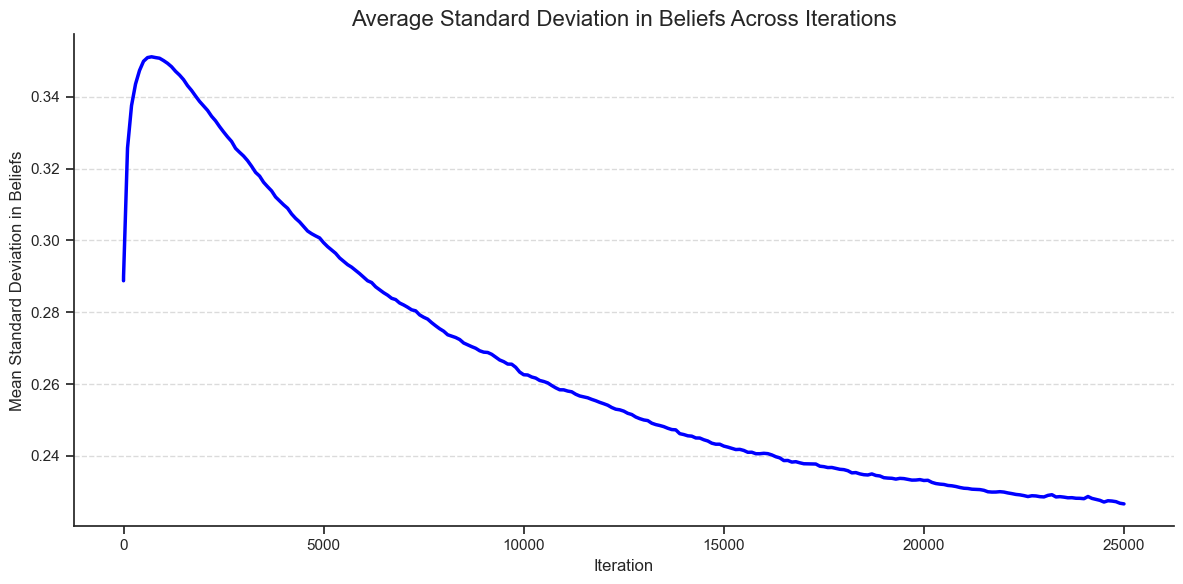

In [8]:
# Plot the result
sns.set_theme(style="ticks")
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_std_by_iteration, x="iteration", y="mean_std_beliefs", color="blue", lw=2.5)

# Add titles and labels
plt.title("Average Standard Deviation in Beliefs Across Iterations", fontsize=16)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Mean Standard Deviation in Beliefs", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()


In [9]:
# Compute the average standard deviation across sims at each iteration and add to aggregated_beliefs
aggregated_std = (
    std_per_sim.groupby("iteration")
    .agg(mean_std_beliefs=("std_beliefs", "mean"))
    .reset_index()
)

# Merge with aggregated_beliefs for iteration-level aggregation
aggregated_beliefs = pd.merge(aggregated_beliefs, aggregated_std, on="iteration", how="left")


In [10]:
aggregated_beliefs

,op,iteration,mean_beliefs,median_beliefs,std_beliefs,min_beliefs,max_beliefs,p25_beliefs,p75_beliefs,mean_std_beliefs
0,BalaGoyalOp,0,0.499408,0.499355,0.288425,0.000006,0.999983,0.249112,0.74951,0.288759
1,BalaGoyalOp,1,0.500695,0.50094,0.290212,0.000008,0.999982,0.247771,0.754314,0.290025
2,BalaGoyalOp,100,0.549492,0.577514,0.334699,0.0,1.0,0.240645,0.873266,0.325717
3,BalaGoyalOp,200,0.584292,0.641665,0.346922,0.0,1.0,0.262126,0.929545,0.337513
4,BalaGoyalOp,300,0.613346,0.699643,0.352041,0.0,1.0,0.289662,0.963901,0.343523
...,...,...,...,...,...,...,...,...,...,...
1507,UnreliableNetworkModifiedAlignedNegativeEpsOp,24600,0.795627,0.999981,0.352806,0.0,1.0,0.743797,1.0,0.227514
1508,UnreliableNetworkModifiedAlignedNegativeEpsOp,24700,0.795372,0.999982,0.352971,0.0,1.0,0.744057,1.0,0.227431
1509,UnreliableNetworkModifiedAlignedNegativeEpsOp,24800,0.797065,0.999983,0.35166,0.0,1.0,0.751271,1.0,0.227259
1510,UnreliableNetworkModifiedAlignedNegativeEpsOp,24900,0.798718,0.999984,0.350696,0.0,1.0,0.76042,1.0,0.226817


In [11]:
ops = aggregated_beliefs["op"].unique()
results = pd.DataFrame()

for idx, op in enumerate(ops):
    for other_op in ops[idx + 1:]:
        # Compare distributions of mean beliefs
        test_result = kstest(
            aggregated_beliefs[aggregated_beliefs["op"] == op]["mean_beliefs"],
            aggregated_beliefs[aggregated_beliefs["op"] == other_op]["mean_beliefs"]
        )
        # Store results
        results = pd.concat([
            results,
            pd.DataFrame({
                "comparison": [f"{op} vs {other_op}"],
                "statistic": test_result.statistic,
                "pvalue": test_result.pvalue
            })
        ])

pd.options.display.float_format = "{:,.4f}".format
print(results.set_index("comparison"))

                                                    statistic  pvalue
comparison                                                           
BalaGoyalOp vs UnreliableNetworkBasicGullibleBi...     0.6706  0.0000
BalaGoyalOp vs UnreliableNetworkBasicGullibleNe...     0.9087  0.0000
BalaGoyalOp vs UnreliableNetworkIdealOp                0.6349  0.0000
BalaGoyalOp vs UnreliableNetworkModifiedAligned...     0.7619  0.0000
BalaGoyalOp vs UnreliableNetworkModifiedAligned...     0.9286  0.0000
UnreliableNetworkBasicGullibleBinomialOp vs Unr...     0.8452  0.0000
UnreliableNetworkBasicGullibleBinomialOp vs Unr...     0.3095  0.0000
UnreliableNetworkBasicGullibleBinomialOp vs Unr...     0.4960  0.0000
UnreliableNetworkBasicGullibleBinomialOp vs Unr...     0.8849  0.0000
UnreliableNetworkBasicGullibleNegativeEpsOp vs ...     0.8730  0.0000
UnreliableNetworkBasicGullibleNegativeEpsOp vs ...     0.7222  0.0000
UnreliableNetworkBasicGullibleNegativeEpsOp vs ...     0.6111  0.0000
UnreliableNetworkIde

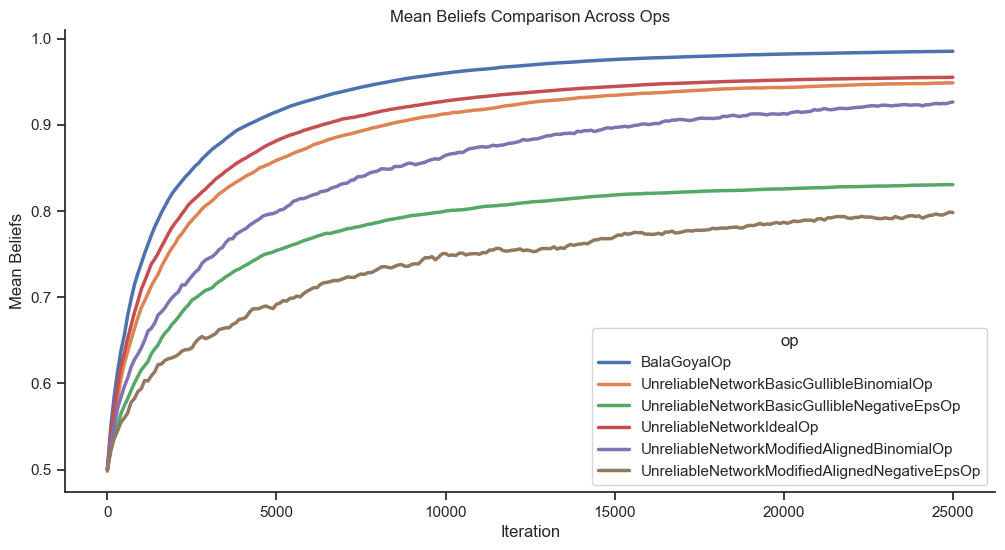

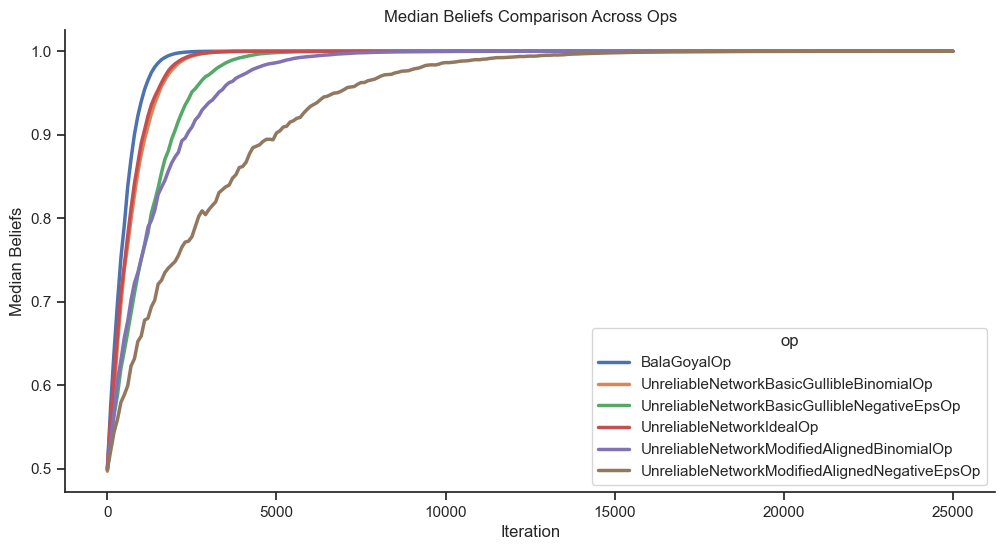

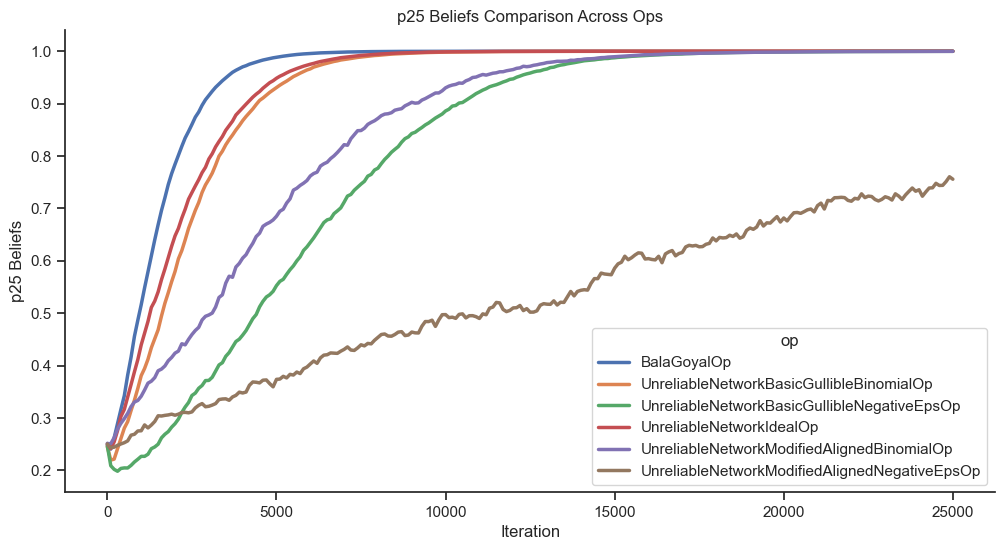

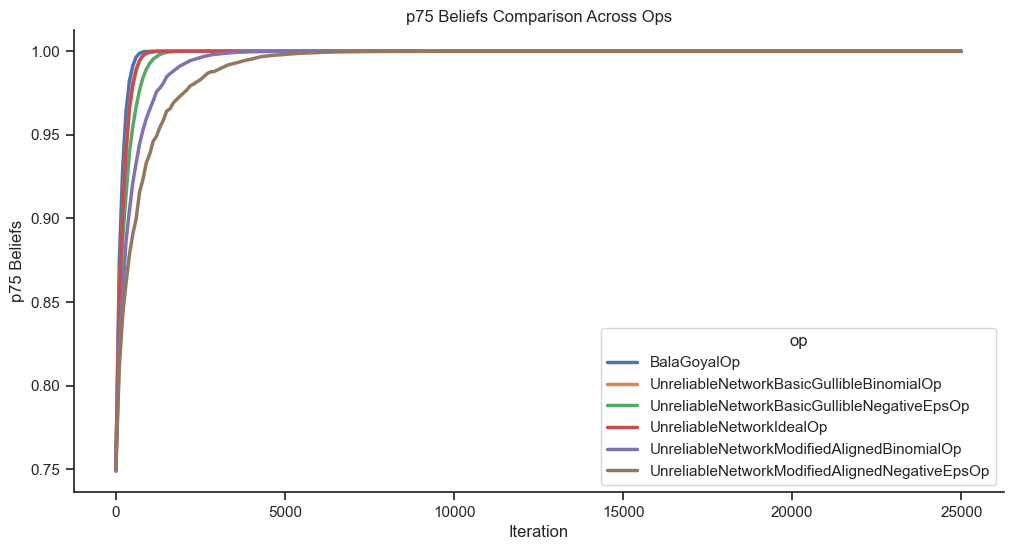

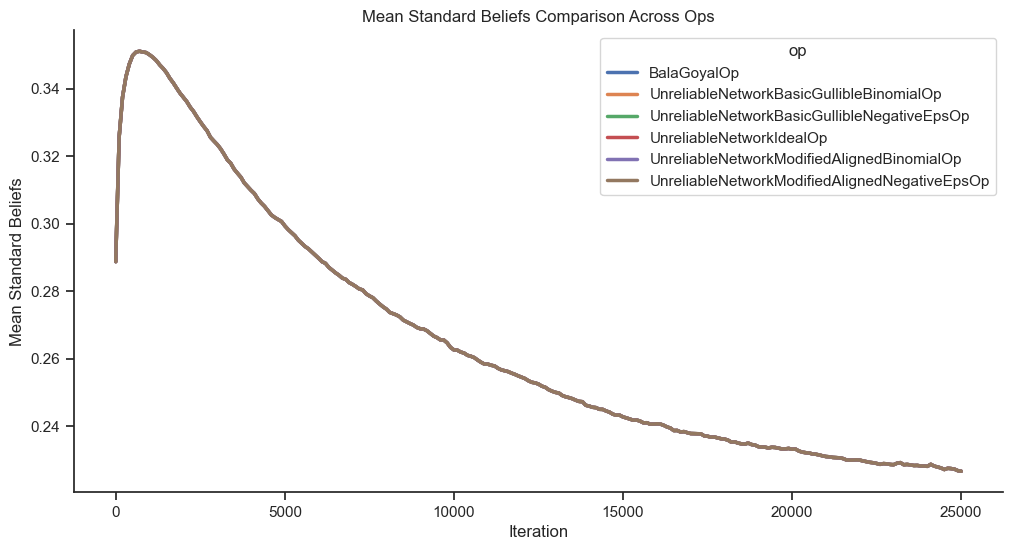

In [12]:
beliefs = {
    'mean_beliefs': 'Mean Beliefs', 
    'median_beliefs': 'Median Beliefs', 
    "p25_beliefs": 'p25 Beliefs', 
    "p75_beliefs": 'p75 Beliefs',
    "mean_std_beliefs": 'Mean Standard Beliefs'
}

for key, value in beliefs.items():
    sns.set_theme(style="ticks")
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=aggregated_beliefs,
                x="iteration",
                y=key,
                hue="op",
                lw=2.5)
    plt.title(f"{value} Comparison Across Ops")
    plt.ylabel(value)
    plt.xlabel("Iteration")
    sns.despine()
    plt.show()

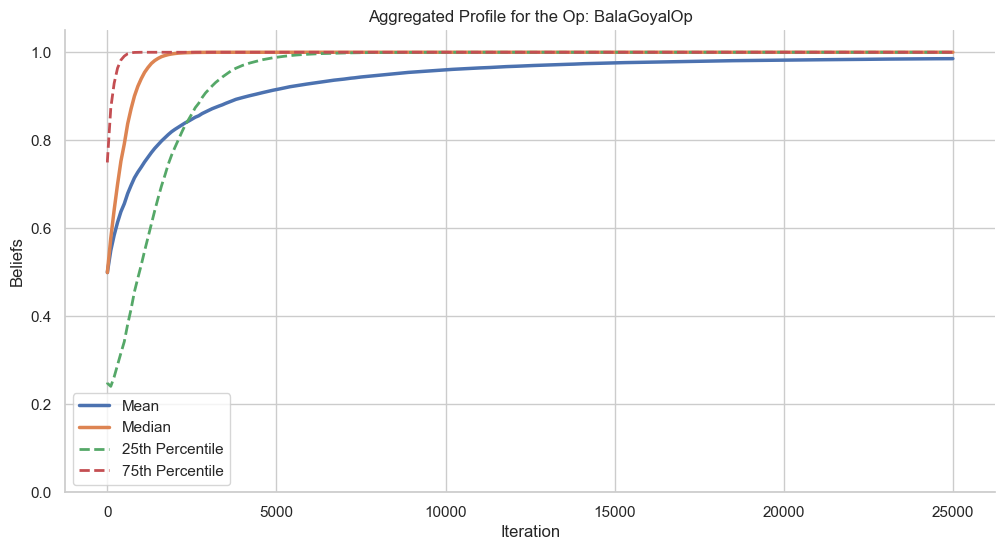

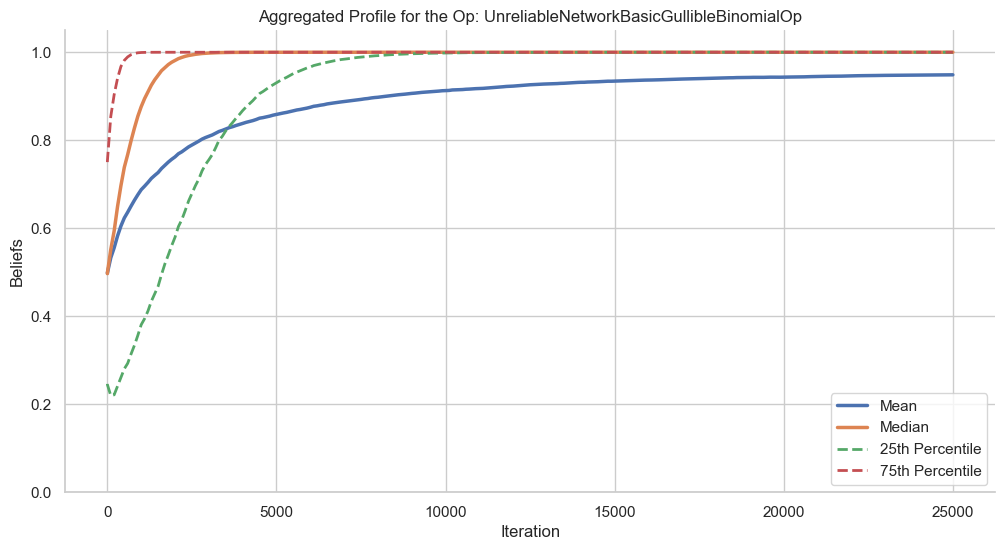

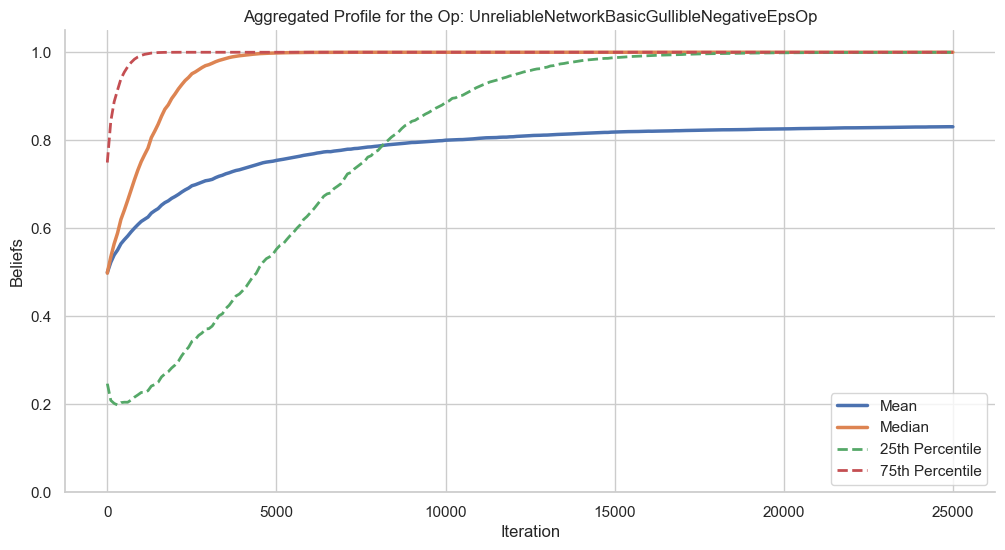

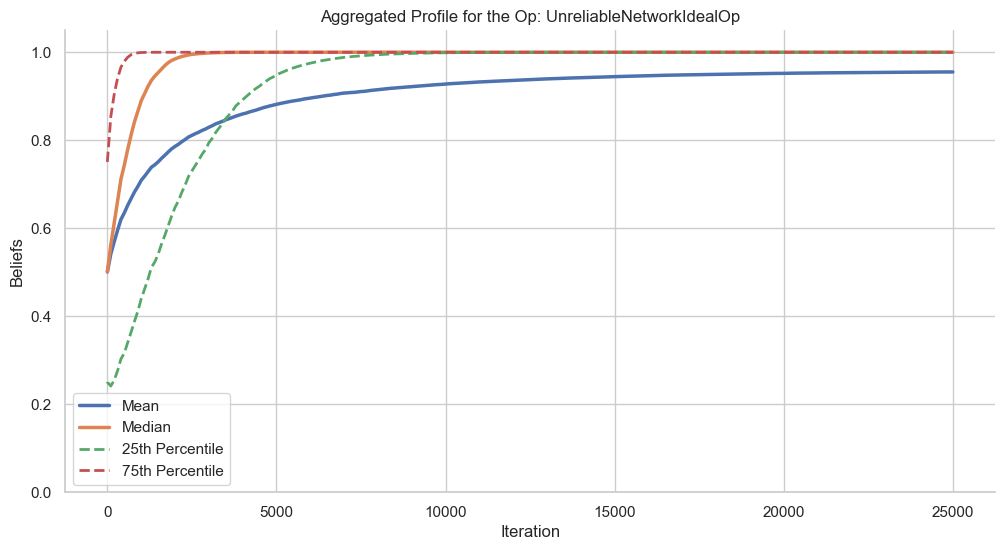

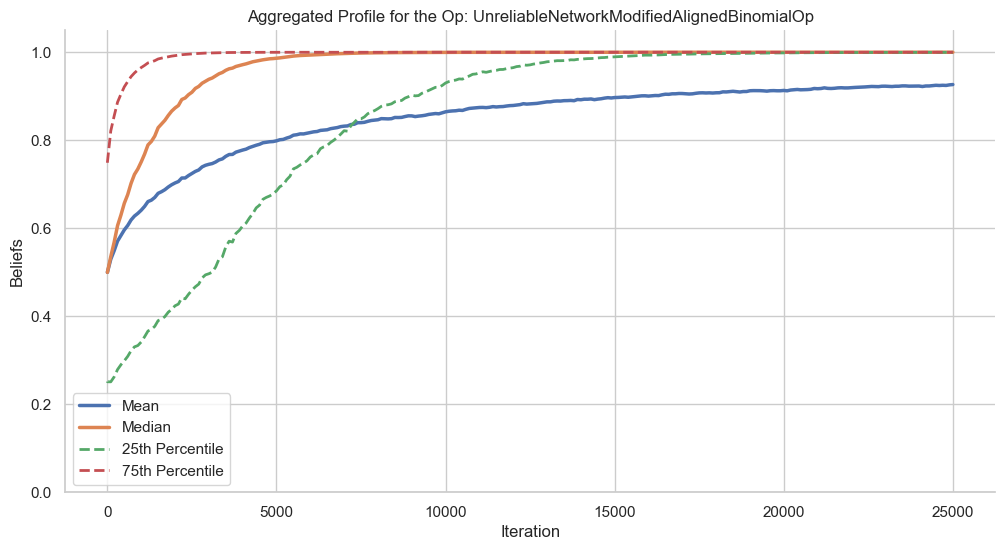

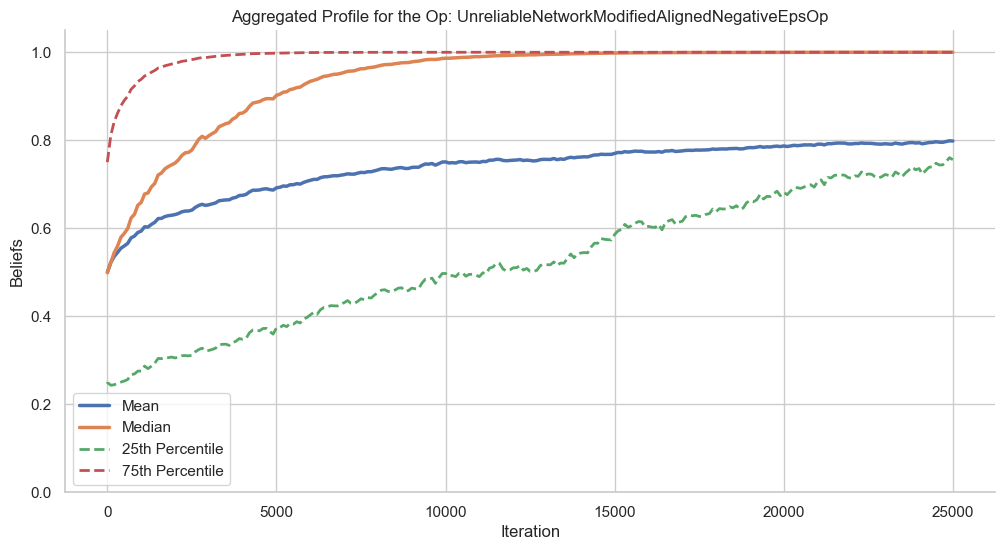

In [13]:
# Aggregated Profile for Each Operator
sns.set_theme(style="whitegrid")
unique_ops = aggregated_beliefs["op"].unique()

for op in unique_ops:
    op_data = aggregated_beliefs[aggregated_beliefs["op"] == op]
    
    plt.figure(figsize=(12, 6))
    plt.plot(op_data["iteration"], op_data["mean_beliefs"], label="Mean", lw=2.5)
    plt.plot(op_data["iteration"], op_data["median_beliefs"], label="Median", lw=2.5)
    plt.plot(op_data["iteration"], op_data["p25_beliefs"], label="25th Percentile", linestyle='--', lw=2)
    plt.plot(op_data["iteration"], op_data["p75_beliefs"], label="75th Percentile", linestyle='--', lw=2)
    # plt.plot(op_data["iteration"], op_data["min_beliefs"], label="Min", linestyle=':', lw=2)
    # plt.plot(op_data["iteration"], op_data["max_beliefs"], label="Max", linestyle=':', lw=2)
    
    plt.title(f"Aggregated Profile for the Op: {op}")
    plt.xlabel("Iteration")
    plt.ylabel("Beliefs")
    plt.ylim(0, 1.05)
    plt.legend()
    sns.despine()
    plt.show()
